#Goal: RMSE 1.005

#Student ID

In [1]:
STUDENT_ID = '20491384'

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Download Data

In [3]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/Ea7QgUR0Cp9Hu7cB6ApBqG8BPv4dlpSUzbqu4xa4Lv-rfw?download=1 -O "Project3 data.zip"
!unzip -q "Project3 data.zip"

# Import Libraries

In [4]:
from collections import Counter
from itertools import combinations
from math import sqrt
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0" #comment out this line if you want to use gpu
import random
from keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from keras.models import Model
from keras.callbacks import Callback, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow

Using TensorFlow backend.


# Set random seed

In [5]:
import random
random.seed(2021)
np.random.seed(2021)
# tf > 2.0
# tensorflow.random.set_seed(2021)
#tf < 2.0
tensorflow.set_random_seed(2021)

#RMSE Calculation

Root Mean Squared Error (RMSE) is used to evaluate the performance of a recommendation algorithm, so we need to define the following utility function to compute the RMSE given the predicted ratings and the ground truth ratings.

In [6]:
'''
params:
    -pred: an array containing all predicted ratings
    -actual: an array containing all ground truth ratings
    
return:
    a scalar whose value is the rmse
'''
def rmse(pred, actual):
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

# Build Wide and Deep Learning (WDL) Model

The wide component is a generalized linear model that takes in the raw input features and the cross-product transformation of categorical features, which enables it to learn the frequent co-occurrence of items or features. 

The deep component is a Feed-forward Neural Network (FNN) which takes in both continuous and categorical features as input. Specifically,  the normalized values of continuous features are concatenated with the low-dimensional dense embedding vectors converted from categorical features. This concatenated vector is then fed into the FNN during each foward pass. This mechanism tend to increase the diversity of recommendations.

In [7]:
'''
params:
    -len_continuous: number of continuous features
    -deep_vocab_lens: an array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep 
        categorical feature
    -len_wide: number of wide features
    -embed_size: dimension of the embedding vectors of deep categorical features
    
return:
    a keras Model object for the constructed wdl model 
'''


def build_wdl_model(len_continuous, deep_vocab_lens, len_wide, embed_size):
    # A list containing all input layers
    input_list = []
    
    # Input layer for continuous features
    continuous_input = Input(shape=(len_continuous,), dtype='float32', name='continuous_input')
    input_list.append(continuous_input)
    
    
    # Get embeddings for all deep categorical features
    emb_list = []
    for vocab_size in deep_vocab_lens:
        _input = Input(shape=(1,), dtype='int32')
        input_list.append(_input)
        _emb = Embedding(output_dim=embed_size, input_dim=vocab_size, input_length=1)(_input)
        _emb = Reshape((embed_size,))(_emb)
        emb_list.append(_emb)

    # Create input layer for deep component by concatenating the embeddings and continuous features' input layer
    deep_input = Concatenate()(emb_list + [continuous_input])
    

    # Construct deep component
    dense_1 = Dense(256, activation='relu')(deep_input)
    dense_1_dp = Dropout(0.3)(dense_1)
    # dense_2 = Dense(128, activation='relu')(dense_1_dp)
    # dense_2_dp = Dropout(0.3)(dense_2)
    # dense_3 = Dense(64, activation='relu')(dense_2_dp)
    # dense_3_dp = Dropout(0.3)(dense_3)
    dense_3_dp = dense_1_dp

    
    # Create input layer for wide component
    wide_input = Input(shape=(len_wide,), dtype='float32')
    input_list.append(wide_input)

    
    # Concatenate the outputs of deep and wide components and feed the 
    # concatenated vector into the finall fully connected layer
    fc_input = Concatenate()([dense_3_dp, wide_input])
    model_output = Dense(1)(fc_input)
    
    model = Model(inputs=input_list,
                  outputs=model_output)
    return model

# Utility functions to get the values of different types of features

## Continuous features

In [8]:
'''
params:
    -df: input dataframe
    -continuous_columns: column names of continuous features
    
return: 
    a numpy array where each row contains the values of continuous features in the corresponding row of the
    input dataframe
'''
def get_continuous_features(df, continuous_columns):
    continuous_features = df[continuous_columns].values
    return continuous_features

## Cross product transformation of categorical features

In [9]:
'''
params:
    -df: input dataframe
    -comb_p: number of elements in each combination (e.g., there are two elements in the combination {fried chicken, chicken and 
    waffle}, and three elements in the combination {fried chicken, chicken and waffle, chicken fried rice})
    -topk: number of mostly frequent combinations to retrieve
    -output_freq: whether to return the frequencies of retrieved combinations
    
return:
    1. output_freq = True: a list X where each element is a tuple containing a combinantion tuple and corresponding frequency, and the 
        elements are stored in the descending order of their frequencies
    2. output_freq = False: a list X where each element is a tuple containing a combinantion tuple, and the elements are stored in 
    the descending order of their frequencies
'''
def get_top_k_p_combinations(df, comb_p, topk, output_freq=False):
    # get all combinations with comb_p
    def get_category_combinations(categories_str, comb_p=2):
        categories = categories_str.split(', ')
        return list(combinations(categories, comb_p))
    # [('Lounges', 'Dance Clubs'), ('Lounges', 'Bars'), ('Lounges', 'Nightlife'), ('Dance Clubs', 'Bars'), ('Dance Clubs', 'Nightlife'), ('Bars', 'Nightlife')]
    all_categories_p_combos = df["item_categories"].apply(
        lambda x: get_category_combinations(x, comb_p)).values.tolist()
    # ('Lounges', 'Dance Clubs')
    # list of tuples that each index refer to one combination
    all_categories_p_combos = [tuple(t) for item in all_categories_p_combos for t in item]

    tmp = dict(Counter(all_categories_p_combos))
    sorted_categories_combinations = list(sorted(tmp.items(), key=lambda x: x[1], reverse=True))
    if output_freq:
        return sorted_categories_combinations[:topk]
    else:
        return [t[0] for t in sorted_categories_combinations[:topk]]

## Wide features

In [10]:
'''
params:
    -df: input dataframe
    -selected_categories_to_idx: a dictionary mapping item categories to corrresponding integral indices
    -top_combinations: a list containing retrieved mostly frequent combinantions of item categories
    
return:
    a numpy array where each row contains the categorical features' binary encodings and cross product
    transformations for the corresponding row of the input dataframe
'''

def get_wide_features(df, selected_categories_to_idx, top_combinations):
    def categories_to_binary_output(categories):
        binary_output = [0 for _ in range(len(selected_categories_to_idx))]
        for category in categories.split(', '):
            if category in selected_categories_to_idx:
                binary_output[selected_categories_to_idx[category]] = 1
            else:
                binary_output[0] = 1
        return binary_output
    def categories_cross_transformation(categories):
        current_category_set = set(categories.split(', '))
        corss_transform_output = [0 for _ in range(len(top_combinations))]
        for k, comb_k in enumerate(top_combinations):
            if len(current_category_set & comb_k) == len(comb_k):
                corss_transform_output[k] = 1
            else:
                corss_transform_output[k] = 0
        return corss_transform_output

    category_binary_features = np.array(df.item_categories.apply(
        lambda x: categories_to_binary_output(x)).values.tolist())
    print('category_binary_features shape:',category_binary_features.shape)
    category_corss_transform_features = np.array(df.item_categories.apply(
        lambda x: categories_cross_transformation(x)).values.tolist())
    print('category_cross_features shape:',category_corss_transform_features.shape)
    out = np.concatenate((category_binary_features, category_corss_transform_features), axis=1)
    print('wide features shape:',out.shape)
    return np.concatenate((category_binary_features, category_corss_transform_features), axis=1)

# Rating Prediction

## Load train, validation and test rating tables

In [11]:
tr_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/valid.csv")
te_df = pd.read_csv("data/test.csv")

tr_ratings = tr_df.stars.values
val_ratings = val_df.stars.values

In [12]:
np.unique(tr_ratings), np.unique(val_ratings)

(array([1., 2., 3., 4., 5.]), array([1., 2., 3., 4., 5.]))

## Load content feautures tables of users and items

In [13]:
user_df = pd.read_csv("data/user.csv")
item_df = pd.read_csv("data/business.csv")

In [14]:
user_df.head()

,Unnamed: 0,user_id,name,review_count,yelping_since,useful,funny,cool,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,0,f04e1b175716b9ff46f0f58d14f65cbe,Karen,85,2008-07-13 17:51:38,63,25,45,"2017,2018",4,4.40,1,0,0,0,0,1,3,1,1,3,0
1,1,9de9e40b3727c667a5b7c1664aa59a5b,Bobby,376,2010-03-10 23:55:33,1754,1036,1124,"2013,2014,2015,2016,2017,2018",39,3.64,47,6,2,2,1,38,77,106,106,52,3
2,2,41a23c92933408a7fd98abed3d3d0071,Michele,244,2011-02-01 01:29:47,435,76,145,NaN,23,4.38,6,5,0,1,0,4,13,13,13,9,6
3,3,1e8b87bf395e036ba5eff80e8b47d509,Christopher,267,2011-05-18 23:00:16,1438,767,1157,"2013,2014,2015,2016,2017,2018",49,3.83,44,8,2,0,0,39,71,146,146,107,3
4,4,344c541cfca0e120924456e8c8cfd468,Lamiya,55,2012-05-05 19:02:11,71,31,52,NaN,2,4.16,1,0,0,0,0,0,3,1,1,0,0


In [15]:
item_df.head()

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,0,de9d8b06461fa8193081e69d4e3ae345,Apteka,4606 Penn Ave,Pittsburgh,PA,15224,40.465694,-79.949324,4.5,242,1,"{'CoatCheck': 'False', 'BusinessParking': ""{'g...","Nightlife, Bars, Polish, Modern European, Rest...","{'Wednesday': '17:0-0:0', 'Thursday': '17:0-0:..."
1,1,334a85d83ec4545b5b2b4581e5182c47,Nee House Chinese Restaurant,"13843 N Tatum Blvd, Ste 15",Phoenix,AZ,85032,33.613020,-111.977036,3.5,269,1,"{'Caters': 'True', 'GoodForKids': 'True', 'Noi...","Chinese, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
2,2,d39623cbcc490dff7ec1036a4f43a337,Vintage 95,95 W Boston,Chandler,AZ,85225,33.302093,-111.842613,4.0,320,0,"{'OutdoorSeating': 'True', 'HasTV': 'True', 'N...","American (New), Bars, Wine Bars, Nightlife, Re...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
3,3,218d525e3a7223a9e2265c2ea481116d,Served,"1770 W Horizon Ridge, Ste 100",Henderson,NV,89012,36.010745,-115.064803,4.5,664,1,"{'DriveThru': 'False', 'RestaurantsAttire': ""'...","Ethnic Food, American (New), Burgers, Food, Re...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '..."
4,4,d5062bde99f4003b7b7ef546c16cf0cc,JJ's Red Hots - Dilworth,1514 East Blvd,Charlotte,NC,28203,35.199798,-80.842295,4.0,380,1,"{'RestaurantsReservations': 'True', 'BusinessA...","Caterers, Hot Dogs, Restaurants, Vegetarian, A...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


In [16]:
# Rename some columns of dfs and convert the indices of dfs into string type for easier reference in later stage 
user_df = user_df.rename(index=str, columns={t: 'user_' + t for t in user_df.columns if t != 'user_id'})
item_df = item_df.rename(index=str, columns={t: 'item_' + t for t in item_df.columns if t != 'business_id'})

In [17]:
user_df.head()

,user_Unnamed: 0,user_id,user_name,user_review_count,user_yelping_since,user_useful,user_funny,user_cool,user_elite,user_fans,user_average_stars,user_compliment_hot,user_compliment_more,user_compliment_profile,user_compliment_cute,user_compliment_list,user_compliment_note,user_compliment_plain,user_compliment_cool,user_compliment_funny,user_compliment_writer,user_compliment_photos
0,0,f04e1b175716b9ff46f0f58d14f65cbe,Karen,85,2008-07-13 17:51:38,63,25,45,"2017,2018",4,4.40,1,0,0,0,0,1,3,1,1,3,0
1,1,9de9e40b3727c667a5b7c1664aa59a5b,Bobby,376,2010-03-10 23:55:33,1754,1036,1124,"2013,2014,2015,2016,2017,2018",39,3.64,47,6,2,2,1,38,77,106,106,52,3
2,2,41a23c92933408a7fd98abed3d3d0071,Michele,244,2011-02-01 01:29:47,435,76,145,NaN,23,4.38,6,5,0,1,0,4,13,13,13,9,6
3,3,1e8b87bf395e036ba5eff80e8b47d509,Christopher,267,2011-05-18 23:00:16,1438,767,1157,"2013,2014,2015,2016,2017,2018",49,3.83,44,8,2,0,0,39,71,146,146,107,3
4,4,344c541cfca0e120924456e8c8cfd468,Lamiya,55,2012-05-05 19:02:11,71,31,52,NaN,2,4.16,1,0,0,0,0,0,3,1,1,0,0


In [18]:
item_df.head()

,item_Unnamed: 0,business_id,item_name,item_address,item_city,item_state,item_postal_code,item_latitude,item_longitude,item_stars,item_review_count,item_is_open,item_attributes,item_categories,item_hours
0,0,de9d8b06461fa8193081e69d4e3ae345,Apteka,4606 Penn Ave,Pittsburgh,PA,15224,40.465694,-79.949324,4.5,242,1,"{'CoatCheck': 'False', 'BusinessParking': ""{'g...","Nightlife, Bars, Polish, Modern European, Rest...","{'Wednesday': '17:0-0:0', 'Thursday': '17:0-0:..."
1,1,334a85d83ec4545b5b2b4581e5182c47,Nee House Chinese Restaurant,"13843 N Tatum Blvd, Ste 15",Phoenix,AZ,85032,33.613020,-111.977036,3.5,269,1,"{'Caters': 'True', 'GoodForKids': 'True', 'Noi...","Chinese, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
2,2,d39623cbcc490dff7ec1036a4f43a337,Vintage 95,95 W Boston,Chandler,AZ,85225,33.302093,-111.842613,4.0,320,0,"{'OutdoorSeating': 'True', 'HasTV': 'True', 'N...","American (New), Bars, Wine Bars, Nightlife, Re...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
3,3,218d525e3a7223a9e2265c2ea481116d,Served,"1770 W Horizon Ridge, Ste 100",Henderson,NV,89012,36.010745,-115.064803,4.5,664,1,"{'DriveThru': 'False', 'RestaurantsAttire': ""'...","Ethnic Food, American (New), Burgers, Food, Re...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-15:0', '..."
4,4,d5062bde99f4003b7b7ef546c16cf0cc,JJ's Red Hots - Dilworth,1514 East Blvd,Charlotte,NC,28203,35.199798,-80.842295,4.0,380,1,"{'RestaurantsReservations': 'True', 'BusinessA...","Caterers, Hot Dogs, Restaurants, Vegetarian, A...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


## Associate each row in the rating tables with corresponding user's and item's content features through merging the rating tables and content features tables

In [19]:
# Save the original row indices of each rating table
tr_df["index"] = tr_df.index
val_df["index"]  = val_df.index
te_df["index"] = te_df.index

tr_df = pd.merge(pd.merge(tr_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)
val_df = pd.merge(pd.merge(val_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)
te_df = pd.merge(pd.merge(te_df, user_df, on='user_id'), item_df, on='business_id').sort_values(by=['index']).reset_index(drop=True)

In [20]:
tr_df.head()

,user_id,business_id,stars,index,user_Unnamed: 0,user_name,user_review_count,user_yelping_since,user_useful,user_funny,user_cool,user_elite,user_fans,user_average_stars,user_compliment_hot,user_compliment_more,user_compliment_profile,user_compliment_cute,user_compliment_list,user_compliment_note,user_compliment_plain,user_compliment_cool,user_compliment_funny,user_compliment_writer,user_compliment_photos,item_Unnamed: 0,item_name,item_address,item_city,item_state,item_postal_code,item_latitude,item_longitude,item_stars,item_review_count,item_is_open,item_attributes,item_categories,item_hours
0,11d83531dcee4af6f5701696ff45a8d8,54eb8c224740ce5a8a1db56324cbf0c0,3.0,0,1666,Jen,75,2007-07-19 00:56:23,150,83,56,NaN,2,3.25,0,0,0,0,0,4,5,2,2,0,1,5188,Four Kegs Sports Bar,"276 N Jones Blvd, Ste B",Las Vegas,NV,89107,36.175904,-115.223262,4.0,441,1,"{'OutdoorSeating': 'False', 'GoodForMeal': ""{'...","American (New), American (Traditional), Sports...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
1,f3270a0bfa9f67f4b00fd9dadbf1d3e4,e398e51ecca29473c80b058ab17e903e,5.0,1,298,Matthew,430,2014-05-27 06:33:22,1713,466,1155,"2016,2017,2018",73,4.58,26,3,1,0,0,11,47,67,67,21,30,4590,Thai Spices,"66 S Dobson Rd, Ste 133",Mesa,AZ,85202,33.412708,-111.875803,4.0,343,1,"{'DogsAllowed': 'False', 'Alcohol': ""u'full_ba...","Thai, Restaurants","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
2,8515478d756cecae1d46ad274e583fba,62d5a2614594cdfe014cb3f47bc1f183,4.0,2,847,Danielle,66,2013-09-27 21:02:56,186,50,98,2015,16,4.03,12,1,0,0,0,7,15,6,6,9,1,3033,Lakeside,3131 Las Vegas Blvd S,Las Vegas,NV,89109,36.126576,-115.166935,3.5,450,1,"{'RestaurantsDelivery': 'False', 'RestaurantsP...","Restaurants, Steakhouses, American (New), Seafood","{'Monday': '17:30-22:0', 'Tuesday': '17:30-22:..."
3,f7a8d4e39387479bee5786d9af7a384e,5e4ad90afb13df5004803bd165a905a9,5.0,3,1153,Lana,247,2013-07-20 22:03:06,363,145,223,"2015,2016,2017,2018",9,3.88,2,0,1,1,0,4,10,10,10,6,1,5268,Saku Sushi,478 Queen Street W,Toronto,ON,M5V 2B2,43.648086,-79.400362,4.0,401,1,"{'HasTV': 'False', 'RestaurantsReservations': ...","Breakfast & Brunch, Sushi Bars, Japanese, Rest...","{'Monday': '12:0-22:30', 'Tuesday': '12:0-23:3..."
4,edbc6b267c51aaa5f89ec35237126649,cff931388a0021c662fa8d3437448a89,2.0,4,368,G,113,2012-04-11 07:50:10,53,11,17,NaN,0,3.68,0,0,0,0,0,2,0,0,0,0,1,4636,Dave & Buster's,"2130 Park Centre Dr, Ste 100",Las Vegas,NV,89135,36.148748,-115.332187,3.0,473,1,"{'Caters': 'False', 'RestaurantsTakeOut': 'Tru...","Restaurants, Arts & Entertainment, Sports Bars...","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ..."


In [21]:
tr_df.item_attributes

0        {'OutdoorSeating': 'False', 'GoodForMeal': "{'...
1        {'DogsAllowed': 'False', 'Alcohol': "u'full_ba...
2        {'RestaurantsDelivery': 'False', 'RestaurantsP...
3        {'HasTV': 'False', 'RestaurantsReservations': ...
4        {'Caters': 'False', 'RestaurantsTakeOut': 'Tru...
                               ...                        
60075    {'BusinessAcceptsCreditCards': 'True', 'Music'...
60076    {'NoiseLevel': "u'loud'", 'Caters': 'False', '...
60077    {'RestaurantsPriceRange2': '3', 'WiFi': "u'pai...
60078    {'DogsAllowed': 'False', 'NoiseLevel': "u'aver...
60079    {'RestaurantsDelivery': 'False', 'RestaurantsA...
Name: item_attributes, Length: 60080, dtype: object

## Prepare continuous features

In [22]:
# Specify the columns containing conitnuous features
# continuous_columns = ["user_average_stars", "user_cool", "user_fans", 
#                       "user_review_count", "user_useful", "user_funny",
#                       "item_is_open", "item_latitude", "item_longitude", 
#                       "item_review_count", "item_stars"]

continuous_columns = ["user_review_count", "user_useful", "user_funny", "user_cool", 
                      "user_fans", "user_average_stars", "user_compliment_hot", 
                      "user_compliment_more", "user_compliment_profile", "user_compliment_cute", 
                      "user_compliment_list", "user_compliment_note", "user_compliment_plain", 
                      "user_compliment_cool", "user_compliment_funny", "user_compliment_writer", 
                      "user_compliment_photos", "item_latitude", "item_longitude", "item_stars", 
                      "item_review_count", "item_is_open"]


# Get values of continous features for train/validation/test sets using the utility function defined previously

tr_continuous_features = get_continuous_features(tr_df, continuous_columns)
val_continuous_features = get_continuous_features(val_df, continuous_columns)
te_continuous_features = get_continuous_features(te_df, continuous_columns)

# Standardize each feature by removing the mean of the training samples and scaling to unit variance.
# See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html for more details.
scaler = StandardScaler().fit(tr_continuous_features)

tr_continuous_features = scaler.transform(tr_continuous_features)
val_continuous_features = scaler.transform(val_continuous_features)
te_continuous_features = scaler.transform(te_continuous_features)

## Prepare deep categorical features

In [23]:
# Sepcify column names of deep categorical features
item_deep_columns = ["item_city", "item_postal_code", "item_state"]

# An array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
item_deep_vocab_lens = []

for col_name in item_deep_columns:
    # Get all unique values of this deep categorical feature
    tmp = item_df[col_name].unique()
    
    # Create a dictionary mapping each unique value to a unique integral index
    vocab = dict(zip(tmp, range(1, len(tmp) + 1)))
    
    # Get the number of unique values of this deep categorical features
    item_deep_vocab_lens.append(len(vocab) + 1)
    
    # Create a new column where each entry stores the integral index of this deep categorical feature's value in the same row
    item_df[col_name + "_idx"] = item_df[col_name].apply(lambda x: vocab[x])


# Create a dictionary mapping each business id to corresponding values of deep categorical features
item_deep_idx_columns = [t + "_idx" for t in item_deep_columns]
item_to_deep_categorical_features = dict(zip(item_df.business_id.values, item_df[item_deep_idx_columns].values.tolist()))

# Creat numpy arrays storing corresponding deep categorical features' values of train/validation/test sets using the above mapping
tr_deep_categorical_features = np.array(tr_df.business_id.apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())
val_deep_categorical_features = np.array(val_df.business_id.apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())
te_deep_categorical_features = np.array(te_df.business_id.apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())

In [24]:
tr_deep_categorical_features.shape

(60080, 3)

In [25]:
item_deep_vocab_lens

[118, 799, 14]

## Prepare wide features

### Prepare binary encoding for each selected category

In [26]:
# Collect the categories of all items 
all_categories = [category for category_list in item_df.item_categories.values for category in category_list.split(", ")]

# Sort all unique values of the item categories by their frequencies in descending order
category_sorted = sorted(Counter(all_categories).items(), key=lambda x: x[1], reverse=True)

# Select top 500 most frequent categories
selected_categories = [t[0] for t in category_sorted[:500]]

# Create a dictionary mapping each secleted category to a unique integral index
selected_categories_to_idx = dict(zip(selected_categories, range(1, len(selected_categories) + 1)))

# Map all categories unseen in the item df to index 0
selected_categories_to_idx['unk'] = 0

# Create a dictionary mapping each integral index to corresponding category
idx_to_selected_categories = {val: key for key, val in selected_categories_to_idx.items()}

In [27]:
len(category_sorted)

605

### Prepare cross product transformation for categories

In [28]:
# Get most frequent categories combinantions using the utility function defined previously and store them in the folloing list
top_combinations = []

# Get top 50 most frequent two-categories combinantions in the train set

top_combinations += get_top_k_p_combinations(tr_df, 2, 50, output_freq=False)

# Get top 30 most frequent three-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 3, 30, output_freq=False)

# Get top 20 most frequent four-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 4, 20, output_freq=False)

# # Get top 70 most frequent two-categories combinantions in the train set

# top_combinations += get_top_k_p_combinations(tr_df, 2, 70, output_freq=False)

# # Get top 20 most frequent three-categories combinantions in the train set
# top_combinations += get_top_k_p_combinations(tr_df, 3, 20, output_freq=False)

# # Get top 10 most frequent four-categories combinantions in the train set
# top_combinations += get_top_k_p_combinations(tr_df, 4, 10, output_freq=False)

# Convert each combinantion in the list to a set data structure
top_combinations = [set(t) for t in top_combinations]

In [29]:
top_combinations

[{'Bars', 'Nightlife'},
 {'Food', 'Restaurants'},
 {'Nightlife', 'Restaurants'},
 {'Bars', 'Nightlife'},
 {'Bars', 'Restaurants'},
 {'Nightlife', 'Restaurants'},
 {'Food', 'Restaurants'},
 {'Bars', 'Restaurants'},
 {'American (New)', 'Restaurants'},
 {'American (New)', 'Restaurants'},
 {'Breakfast & Brunch', 'Restaurants'},
 {'American (Traditional)', 'Restaurants'},
 {'American (Traditional)', 'Restaurants'},
 {'Breakfast & Brunch', 'Restaurants'},
 {'Restaurants', 'Sandwiches'},
 {'Restaurants', 'Seafood'},
 {'American (New)', 'Nightlife'},
 {'American (New)', 'Bars'},
 {'Beer', 'Wine & Spirits'},
 {'Italian', 'Restaurants'},
 {'Mexican', 'Restaurants'},
 {'American (New)', 'Nightlife'},
 {'Restaurants', 'Sandwiches'},
 {'American (New)', 'Bars'},
 {'Japanese', 'Restaurants'},
 {'Breakfast & Brunch', 'Food'},
 {'Burgers', 'Restaurants'},
 {'Burgers', 'Restaurants'},
 {'Mexican', 'Restaurants'},
 {'Italian', 'Restaurants'},
 {'Pizza', 'Restaurants'},
 {'Restaurants', 'Seafood'},
 {'Pi

In [30]:
# Get values of wide features for train/validation/test sets using the utility function defined previously

tr_wide_features = get_wide_features(tr_df, selected_categories_to_idx, top_combinations)
val_wide_features = get_wide_features(val_df, selected_categories_to_idx, top_combinations)
te_wide_features = get_wide_features(te_df, selected_categories_to_idx, top_combinations)

category_binary_features shape: (60080, 501)
category_cross_features shape: (60080, 100)
wide features shape: (60080, 601)
category_binary_features shape: (7510, 501)
category_cross_features shape: (7510, 100)
wide features shape: (7510, 601)
category_binary_features shape: (7510, 501)
category_cross_features shape: (7510, 100)
wide features shape: (7510, 601)


## Build the input list for each of the train/validation/test sets through aggregating all continuous, deep categorical and wide features

In [31]:
# tr_features = [tr_continuous_features,categorical_features_0,categorical_features_1,categorical_features_2,tr_wide_features]
tr_features = []
tr_features.append(tr_continuous_features.tolist())
tr_features += [tr_deep_categorical_features[:,i].tolist() for i in range(tr_deep_categorical_features.shape[1])]
tr_features.append(tr_wide_features.tolist())



val_features = []
val_features.append(val_continuous_features.tolist())
val_features += [val_deep_categorical_features[:,i].tolist() for i in range(val_deep_categorical_features.shape[1])]
val_features.append(val_wide_features.tolist())

te_features = []
te_features.append(te_continuous_features.tolist())
te_features += [te_deep_categorical_features[:,i].tolist() for i in range(te_deep_categorical_features.shape[1])]
te_features.append(te_wide_features.tolist())

## WDL model

In [32]:
wdl_model = build_wdl_model(
        len(tr_continuous_features[0]),
        item_deep_vocab_lens,   # num of category classes
        len(tr_wide_features[0]), 
        embed_size=100)
print(len(tr_continuous_features[0]))
print(item_deep_vocab_lens)
print(len(tr_wide_features[0]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
22
[118, 799, 14]
601


In [33]:
wdl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       11800       input_1[0][0]                    
____________________________________________________________________________________________

## Train the WDL model

In [34]:
wdl_model.compile(optimizer='adagrad', loss='mse')
# wdl_model.compile(optimizer='adam', loss='mse')

history = wdl_model.fit(
        tr_features, 
        tr_ratings, 
        epochs=20, verbose=1, callbacks=[ModelCheckpoint('model.h5')])


Epoch 1/20
60080/60080 [==============================] - 10s 160us/step - loss: 1.1458
Epoch 2/20
60080/60080 [==============================] - 7s 123us/step - loss: 1.0669
Epoch 3/20
60080/60080 [==============================] - 7s 124us/step - loss: 1.0539
Epoch 4/20
60080/60080 [==============================] - 7s 123us/step - loss: 1.0488
Epoch 5/20
60080/60080 [==============================] - 7s 124us/step - loss: 1.0432
Epoch 6/20
60080/60080 [==============================] - 7s 125us/step - loss: 1.0424
Epoch 7/20
60080/60080 [==============================] - 8s 126us/step - loss: 1.0313
Epoch 8/20
60080/60080 [==============================] - 7s 124us/step - loss: 1.0315
Epoch 9/20
60080/60080 [==============================] - 7s 124us/step - loss: 1.0319
Epoch 10/20
60080/60080 [==============================] - 8s 125us/step - loss: 1.0320
Epoch 11/20
60080/60080 [==============================] - 7s 124us/step - loss: 1.0313
Epoch 12/20
60080/60080 [==============

## Evaluate the WDL model on train and validation sets using RMSE

In [35]:
y_pred = wdl_model.predict(tr_features)
print("TRAIN RMSE: ", rmse(y_pred, tr_ratings))
y_pred = wdl_model.predict(val_features)
print("VALID RMSE: ", rmse(y_pred, val_ratings))

TRAIN RMSE:  0.984513364019102
VALID RMSE:  0.9996970942113022


# Evaluate the Validation Predictions using code from evaluate.py

In [36]:
pred_df = val_df[["user_id", "business_id"]]
pred_df["stars"] = y_pred
pred_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,business_id,stars
0,8becc257dd950c530711e297be327e7b,5ed2bef8c901ebdcc96fedf2f4560c79,4.269733
1,6dc9688262188b67fcdaaf30ba5f2b41,5bfc74cc8eaa89e28ae9bbc071770fc4,3.292845
2,97b4eceee3d20c884508469bf093e5c3,c0ab608051317680920ea102073b92e1,4.683703
3,440847a87174f0371f82c9aca88a2c06,9dbd4b0c872e768640b62bf77c18ba59,3.741473
4,d702349096c4afd3791720fdcac583cb,ac74f2fdf664962aaf45f55268e87b05,3.557282


In [37]:
pred_df.to_csv('val_pre.csv')

In [38]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt


val_df = pd.read_csv("data/valid.csv")

pred_df = pd.read_csv('val_pre.csv')

df = pd.merge(val_df, pred_df, how="left", left_on=['user_id', 'business_id'], right_on = ['user_id','business_id'])

df.fillna(0, inplace=True)


print("VALIDATION RMSE: ", rmse(df['stars_y'].values, df['stars_x'].values))

VALIDATION RMSE:  0.9996970952881054


# Test Predictions

In [39]:
y_pred = wdl_model.predict(te_features)
res_df = pd.DataFrame()
res_df['pred'] = y_pred[:, 0]
res_df.to_csv("{}.csv".format(STUDENT_ID), index=False)
print("Writing test predictions to file done.")

Writing test predictions to file done.


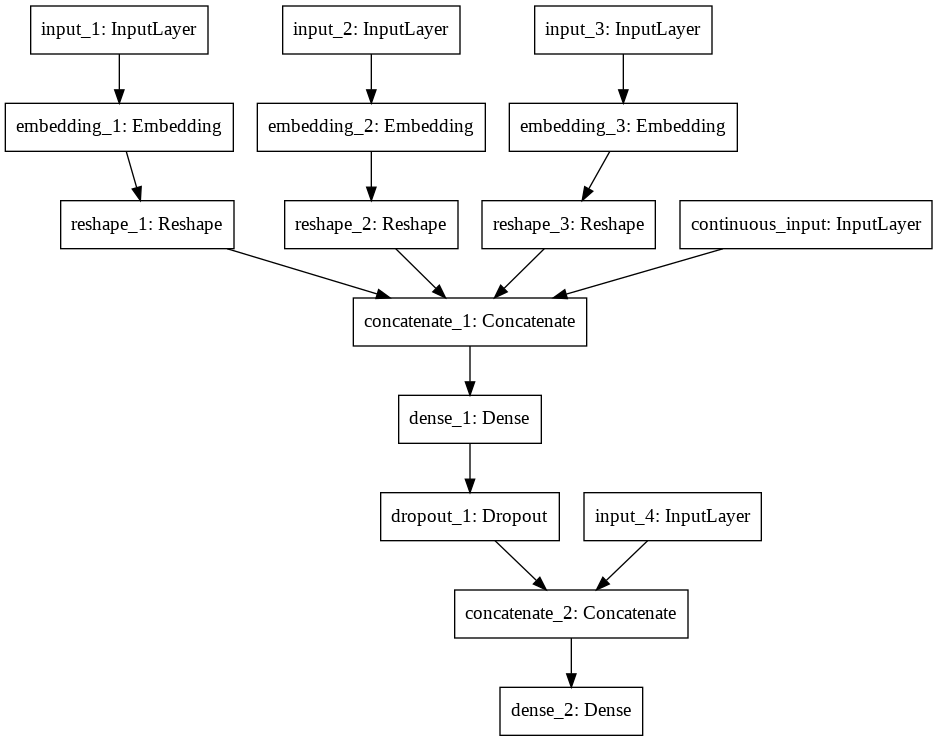

In [40]:
tensorflow.keras.utils.plot_model(wdl_model, to_file='model.png', show_shapes=False)